In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import os, re
import glob

import sklearn
import statsmodels
from sklearn.model_selection import train_test_split 

import tensorflow as tf
from tensorflow import keras
import cv2 
import dlib

# from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

# 경고 문구 off
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Project_MakingFaceStickerApplication

### 1) 사진 준비하기

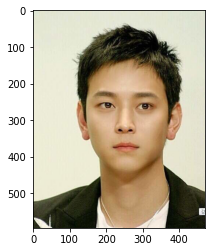

In [4]:
img_bgr = cv2.imread('/content/drive/MyDrive/PNG/KDW3.png') # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy() # 출력용 이미지를 따로 보관
img = img_bgr
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌
plt.show()          # 이미지 실제 출력

### 2) Face Detection

In [5]:
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
dlib_rects = detector_hog(img_rgb, 1)           # (image, num of image pyramid)

rectangles[[(142, 192) (365, 415)]]


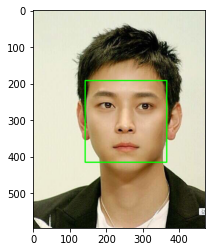

In [6]:
# 찾은 얼굴 영역 박스 리스트

print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left()   # 왼쪽
    t = dlib_rect.top()    # 위쪽
    r = dlib_rect.right()  # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 3) Face Landmark

In [7]:
model_path = '/content/drive/MyDrive/PNG/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [8]:
list_landmarks = []  # 랜드마크의 위치를 저장할 list 생성    

# 얼굴 영역 박스 마다 face landmark를 찾아냄
# face landmark 좌표를 저장
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)  # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))  # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)  # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))

68


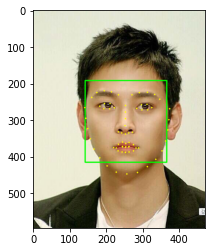

[[(141, 266), (144, 295), (149, 323), (156, 351), (166, 379), (182, 403), (202, 425), (227, 442), (256, 447), (285, 443), (312, 427), (335, 407), (352, 384), (362, 357), (368, 327), (371, 299), (373, 269), (160, 238), (174, 225), (194, 220), (214, 223), (233, 231), (270, 231), (290, 225), (312, 224), (332, 230), (346, 243), (252, 260), (252, 278), (252, 296), (251, 315), (233, 332), (242, 335), (252, 338), (261, 335), (271, 333), (182, 262), (195, 255), (210, 255), (222, 266), (209, 269), (193, 269), (283, 268), (296, 258), (311, 257), (324, 266), (313, 272), (297, 272), (220, 375), (233, 366), (244, 360), (253, 364), (262, 361), (274, 367), (288, 376), (274, 384), (262, 387), (252, 388), (243, 387), (232, 384), (227, 376), (244, 372), (253, 373), (262, 372), (281, 376), (261, 373), (252, 374), (244, 373)]]


In [9]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)  # RGB 이미지로 전환
plt.imshow(img_show_rgb)  # 이미지를 준비
plt.show()                # 이미지를 출력
print(list_landmarks)

### 4) To Apply Face Sticker

In [10]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[[(142, 192) (365, 415)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
# → [[(141, 266), (144, 295), (149, 323), (156, 351), (166, 379), (182, 403), (202, 425), (227, 442), (256, 447), (285, 443), (312, 427), (335, 407), (352, 384), (362, 357), (368, 327), (371, 299), (373, 269), (160, 238), (174, 225), (194, 220), (214, 223), (233, 231), (270, 231), (290, 225), (312, 224), (332, 230), (346, 243), (252, 260), (252, 278), (252, 296), (251, 315), (233, 332), (242, 335), (252, 338), (261, 335), (271, 333), (182, 262), (195, 255), (210, 255), (222, 266), (209, 269), (193, 269), (283, 268), (296, 258), (311, 257), (324, 266), (313, 272), (297, 272), (220, 375), (233, 366), (244, 360), (253, 364), (262, 361), (274, 367), (288, 376), (274, 384), (262, 387), (252, 388), (243, 387), (232, 384), (227, 376), (244, 372), (253, 373), (262, 372), (281, 376), (261, 373), (252, 374), (244, 373)]]

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30])  # 코의 index는 30
    x = landmark[30][0]   # 이미지에서 코 부위의 x값
    y = landmark[30][1]
    w = (landmark[30][0]-landmark[36][0])*2
    h = (landmark[30][1]-landmark[26][1])*2
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(251, 315)
(x,y) : (251,315)
(w,h) : (138,144)


In [11]:
img_sticker = cv2.imread('/content/drive/MyDrive/PNG/catwhiskers.png')
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정
print (img_sticker.shape)

(144, 138, 3)


In [12]:
# x는 이미지에서 코 부위의 x값
# y는 이미지에서 코 부위의 y값
# w는 얼굴 영역의 가로를 차지하는 픽셀의 수
# h는 얼굴 영역의 가로를 차지하는 픽셀의 수
refined_x = x-w//2
refined_y = y-h//2
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정. 이미지 시작점은 top-left 좌표이기 때문
# 즉, refined_x, refined_y값에서 이미지가 시작됨
print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (182,243)


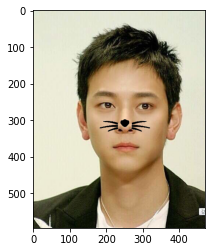

In [13]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 됨
plt.show()

# 2. 얼굴 각도에 따른 스티커 앱 적용시 문제점 & 해결책


### 문제점1 : 얼굴 각도에 따라 스티커 이미지가 축소되었음 → 스티커 이미지 확대 & 회전

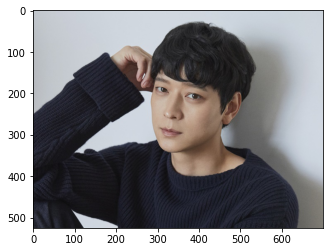

In [14]:
img_bgr = cv2.imread('/content/drive/MyDrive/PNG/KDW2.png')
img_show = img_bgr.copy()
img = img_bgr
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [15]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1) 

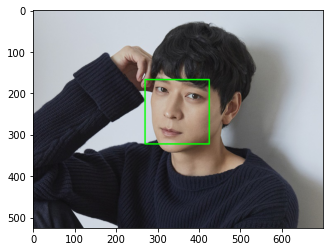

In [16]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

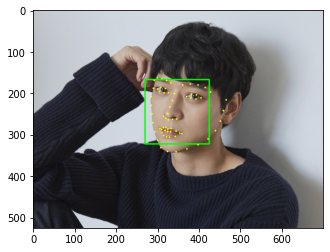

[[(290, 188), (285, 208), (285, 229), (287, 250), (289, 271), (294, 293), (300, 313), (308, 331), (324, 340), (345, 341), (371, 334), (398, 324), (422, 310), (440, 290), (452, 267), (459, 242), (466, 216), (292, 169), (300, 163), (311, 164), (322, 169), (332, 175), (361, 180), (379, 178), (398, 180), (415, 186), (428, 197), (341, 201), (336, 217), (330, 233), (325, 249), (315, 255), (320, 260), (326, 264), (336, 263), (346, 262), (300, 190), (308, 186), (319, 189), (326, 199), (316, 199), (305, 196), (370, 208), (382, 202), (394, 204), (405, 211), (393, 214), (380, 212), (306, 285), (314, 283), (320, 282), (325, 286), (333, 285), (345, 291), (359, 297), (343, 304), (329, 306), (322, 305), (315, 302), (311, 295), (310, 287), (319, 289), (325, 292), (332, 292), (354, 296), (331, 293), (324, 292), (318, 290)]]


In [17]:
model_path = '/content/drive/MyDrive/PNG/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []   
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
print(list_landmarks)

(325, 249)


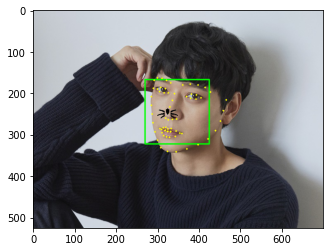

In [18]:
# To Apply Face Sticker

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[30][0]
    y = landmark[30][1]
    w = (landmark[30][0]-landmark[36][0])*2
    h = (landmark[30][1]-landmark[26][1])*2

img_sticker = cv2.imread('/content/drive/MyDrive/PNG/catwhiskers.png')
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x-w//2
refined_y = y-h//2 

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

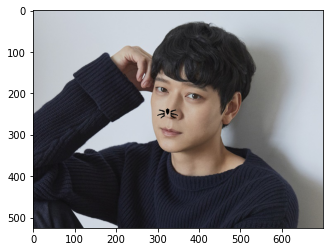

In [19]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### import math : math 모듈을 사용하여 회전

(325, 249)


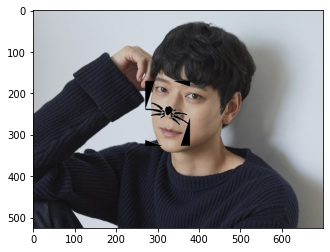

In [20]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[30][0]
    y = landmark[30][1]
    w = (landmark[28][0]-landmark[36][0])*3
    h = (landmark[30][1]-landmark[26][1])*3

img_sticker = cv2.imread('/content/drive/MyDrive/PNG/catwhiskers.png')
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x-w//2
refined_y = y-h//2 

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

import math
height, width, channel = img_sticker.shape
angle = math.atan(h/w)/math.pi*60
matrix = cv2.getRotationMatrix2D((width/2, height/2), -angle, 1)
img_sticker = cv2.warpAffine(img_sticker, matrix, (width, height))

plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점2 : 회전으로 인해 사각형 내 검정색 영역 발생 → getRotationMatrix2D를 이용해 회전

(325, 249)


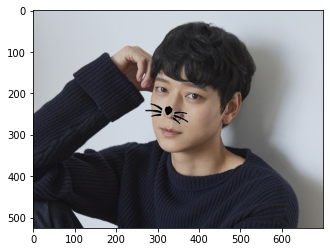

In [21]:
img_bgr = cv2.imread('/content/drive/MyDrive/PNG/KDW2.png')
img_show = img_bgr.copy() 
img = img_bgr
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1) 

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

model_path = '/content/drive/MyDrive/PNG/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []   
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[30][0]
    y = landmark[30][1]
    w = (landmark[28][0]-landmark[36][0])*3
    h = (landmark[30][1]-landmark[26][1])*3

img_sticker = cv2.imread('/content/drive/MyDrive/PNG/catwhiskers.png')
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x-w//2
refined_y = y-h//2  

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
  return result
img_rotate = rotate_image(img_sticker,-15)

sticker_area = img_bgr[refined_y:refined_y+img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]]
img_bgr[refined_y:refined_y+img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]] = np.where(img_rotate==255,sticker_area,img_rotate).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 3. References

[1] https://velog.io/@dldndyd01/OpenCV-이미지-회전중앙-기준-회전-cv2.getRotationMatrix2D-얼굴-회전-각도-구하기

[2] https://lms.aiffel.io/course/382/node/503